## Dataset Lenght of Stay

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

È interessante osservare la distribuzione dei diversi attributi.
Un fatto immediatamente evidente è lo sbilanciamento delle etichette di classe: la maggior parte delle durate di ricovero sono inferiori alla metà del valore massimo.

In [109]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split   #funzioni per dividere il dataset in test/validation/training set
import datetime #fornisce funzioni e classi per lavorare con date e tempi
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator #strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import display, HTML #funzioni utilizzate per visualizzare output HTML nel notebook
import base64 #fornisce funzioni per codificare e decodificare dati binari in stringhe ASCII utilizzando la codifica base64
pd.set_option('future.no_silent_downcasting', True)     # Consente che si possa cambiare il tipo degli attributi nel dataset, servirà in fase di preprocessing


C:\Users\gobba\AppData\Local\Temp\ipykernel_11048\788373187.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML #funzioni utilizzate per visualizzare output HTML nel notebook


Importando il dataset e visualizzando i primi record ci accorgiamo che ci sono degli attributi data, questi non possono essere elaborati direttamente da Tensorflow ma vanno preprocessati e convertiti in valori numerici.
Assegnamo ad ogni data il corrispondente giorno dell'anno da 1 a 365 (o 366 se l'anno e bisestile)

In [110]:
df = pd.read_csv("LengthOfStay.csv") #carica il dataframe in una variabile struttando pandas

Sistemate le date, gli altri attributi a cui dovremo dare una codifica numerica sono:
- rcount: trasformeremo il valore 5+ in 5
- gender: trasformeremo M in 0 ed F 1
- facid: trasformeremo le lettere in numeri incrementali


In [111]:
test_ratio = 0.15
val_ratio = 0.15
data_len = len(df)

train_bound = int(data_len*(1-val_ratio-test_ratio))
val_bound = int(data_len*(1-test_ratio))

df_features = df.iloc[:, 1:-1]
df_labels = df.iloc[:, -1]

x_train, y_train = df_features[:train_bound], df_labels[:train_bound]

In [112]:
fsg = FeatureStatisticsGenerator() #Crea un oggetto FeatureStatisticsGenerator, che è una classe di Facets che genera statistiche dai tuoi dati
dataframes = [ {'table': pd.concat([x_train, y_train], axis=1), 'name': 'trainData'}] #Crea un dizionario con dentro il dataframe
censusProto = fsg.ProtoFromDataFrames(dataframes) # Genera le statistiche dal DataFrame
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8") # codifica dei dati del dataset

# Impostazioni per la visualizzazione (mostra degli attributi evidentemente sbilanciati)
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

c:\Users\gobba\miniconda3\envs\kambinete\lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


A questo punto il dataset ha solamente valori numerici e può essere trattato come un tensore.
Sappiamo che le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati

In [113]:
dates = df["vdate"]     # Date originali
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates] # Date codificate 
encoding_dict = dict(zip(dates, encoded_dates))     # Creazione dizionario di codifica per le date
df.replace({"vdate": encoding_dict}, inplace=True)  # Sostituzione nella colonna

dates = df["discharged"]
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates]
encoding_dict = dict(zip(dates, encoded_dates))
df.replace({"discharged": encoding_dict}, inplace=True)

df.replace({"rcount": dict(zip(sorted(df["rcount"].unique()), range(6)))}, inplace=True)   # Codifica del 5+ in 5 e conversione a interi

df.replace({"gender": "M"}, 0, inplace=True)    # Codifica binaria del genere, assegna 0 a maschio e 1 a femmina
df.replace({"gender": "F"}, 1, inplace=True)

keys = df["facid"].unique()                        # Estrazione dei valori unici dell'attributo
ints = {key: value for value, key in enumerate(keys)}    # Creazione del dizionario di codifica

df.replace({"facid": ints}, inplace=True)                # Codifica del facid

In [114]:
dataset = df.to_numpy() #Converte il dataframe in un array numpy

#divide le colonne del dataset in attributi e label
features = dataset[:, 1:-1]
labels = dataset[:, -1]

#funzione che standardizza i dati nel range [0,1] e li rende di tipo float32
def standardize(dataset: np.ndarray) -> tf.Tensor:
    for i in range(dataset.shape[1]):
        column = dataset[:, i]
        dataset[:, i] = (column - np.min(column)) / (np.max(column) - np.min(column))
    return tf.convert_to_tensor(dataset, dtype=tf.float32)

features = standardize(features) #standardizza i dati nel range [0,1]

#divide i dati in dati in train, validazione e test set
x_train, y_train = features[:train_bound], labels[:train_bound]
x_val, y_val = features[train_bound:val_bound], features[train_bound:val_bound]
x_test, y_test = features[val_bound:], labels[val_bound:]

print(tf.shape(x_train), tf.shape(x_val), tf.shape(x_test)) #stampa le dimensini dei nuovi dataset creati


tf.Tensor([70000    26], shape=(2,), dtype=int32) tf.Tensor([15000    26], shape=(2,), dtype=int32) tf.Tensor([15000    26], shape=(2,), dtype=int32)


In [115]:
import tensorflow as tf
from tfkan.layers import DenseKAN
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


In [116]:

tf.random.set_seed(420)

class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError(name='mse')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        return tf.sqrt(self.mse.result())
        
    def reset_states(self):
        self.mse.reset_states()


# Lista di metrics necessarie per valutare le performance.
METRICS = [
  tf.keras.metrics.MeanSquaredError(name='mse'),
  tf.keras.metrics.MeanAbsoluteError(name='mae'),
  tf.keras.metrics.RootMeanSquaredError(name='rmse')
]

# Parametri gestibili da interfaccia
HIDDEN_UNITS_LAYER_01 = 8 #@param
HIDDEN_UNITS_LAYER_02 = 1 #@param
LEARNING_RATE = 0.01 #@param
EPOCH = 50 #@param


# Creazione del modello KAN
kan = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    DenseKAN(HIDDEN_UNITS_LAYER_02)
])
kan.build(input_shape=(None, 26))
kan.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_2 (DenseKAN)          │ (None, 8)              │         1,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_3 (DenseKAN)          │ (None, 1)              │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,953 (7.63 KB)

 Trainable params: 1,953 (7.63 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

tf.random.set_seed(420)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.keras.losses.MSE(y_true, y_pred))

kan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=[rmse, 'mae'])

kan_history = kan.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)


Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.1848 - mae: 2.1549 - rmse: 2.1549 - val_loss: 1.2130 - val_mae: 0.8456 - val_rmse: 0.8456
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1364 - mae: 0.8096 - rmse: 0.8096 - val_loss: 0.8319 - val_mae: 0.6593 - val_rmse: 0.6593
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8064 - mae: 0.6482 - rmse: 0.6482 - val_loss: 0.7064 - val_mae: 0.5990 - val_rmse: 0.5990
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7089 - mae: 0.6032 - rmse: 0.6032 - val_loss: 0.6641 - val_mae: 0.5780 - val_rmse: 0.5780
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6691 - mae: 0.5850 - rmse: 0.5850 - val_loss: 0.6427 - val_mae: 0.5667 - val_rmse: 0.5667
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6466 - mae: 0.5745 - rmse: 0.5745 - val_loss: 0.6244 - val_mae: 0.5583 - val_rmse: 0.5583
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6297 - mae: 0.5664 - rmse:

In [118]:
# MLP
mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
mlp.build(input_shape=(None, 26))
mlp.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,793 (7.00 KB)

 Trainable params: 1,793 (7.00 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:

mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=[rmse, 'mae'])

mlp_history = mlp.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.4361 - mae: 1.1463 - rmse: 1.1463 - val_loss: 1.1976 - val_mae: 0.8413 - val_rmse: 0.8413
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 1.1936 - mae: 0.8337 - rmse: 0.8337 - val_loss: 1.1327 - val_mae: 0.8251 - val_rmse: 0.8251
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 1.1114 - mae: 0.8007 - rmse: 0.8007 - val_loss: 1.0633 - val_mae: 0.7944 - val_rmse: 0.7944
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 1.0463 - mae: 0.7701 - rmse: 0.7701 - val_loss: 1.0025 - val_mae: 0.7609 - val_rmse: 0.7609
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.9894 - mae: 0.7402 - rmse: 0.7402 - val_loss: 0.9462 - val_mae: 0.7149 - val_rmse: 0.7149
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.9462 - mae: 0.7173 - rmse: 0.7173 - val_loss: 0.8998 - val_mae: 0.6861 - val_rmse: 0.6861
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.9010 - mae: 0.

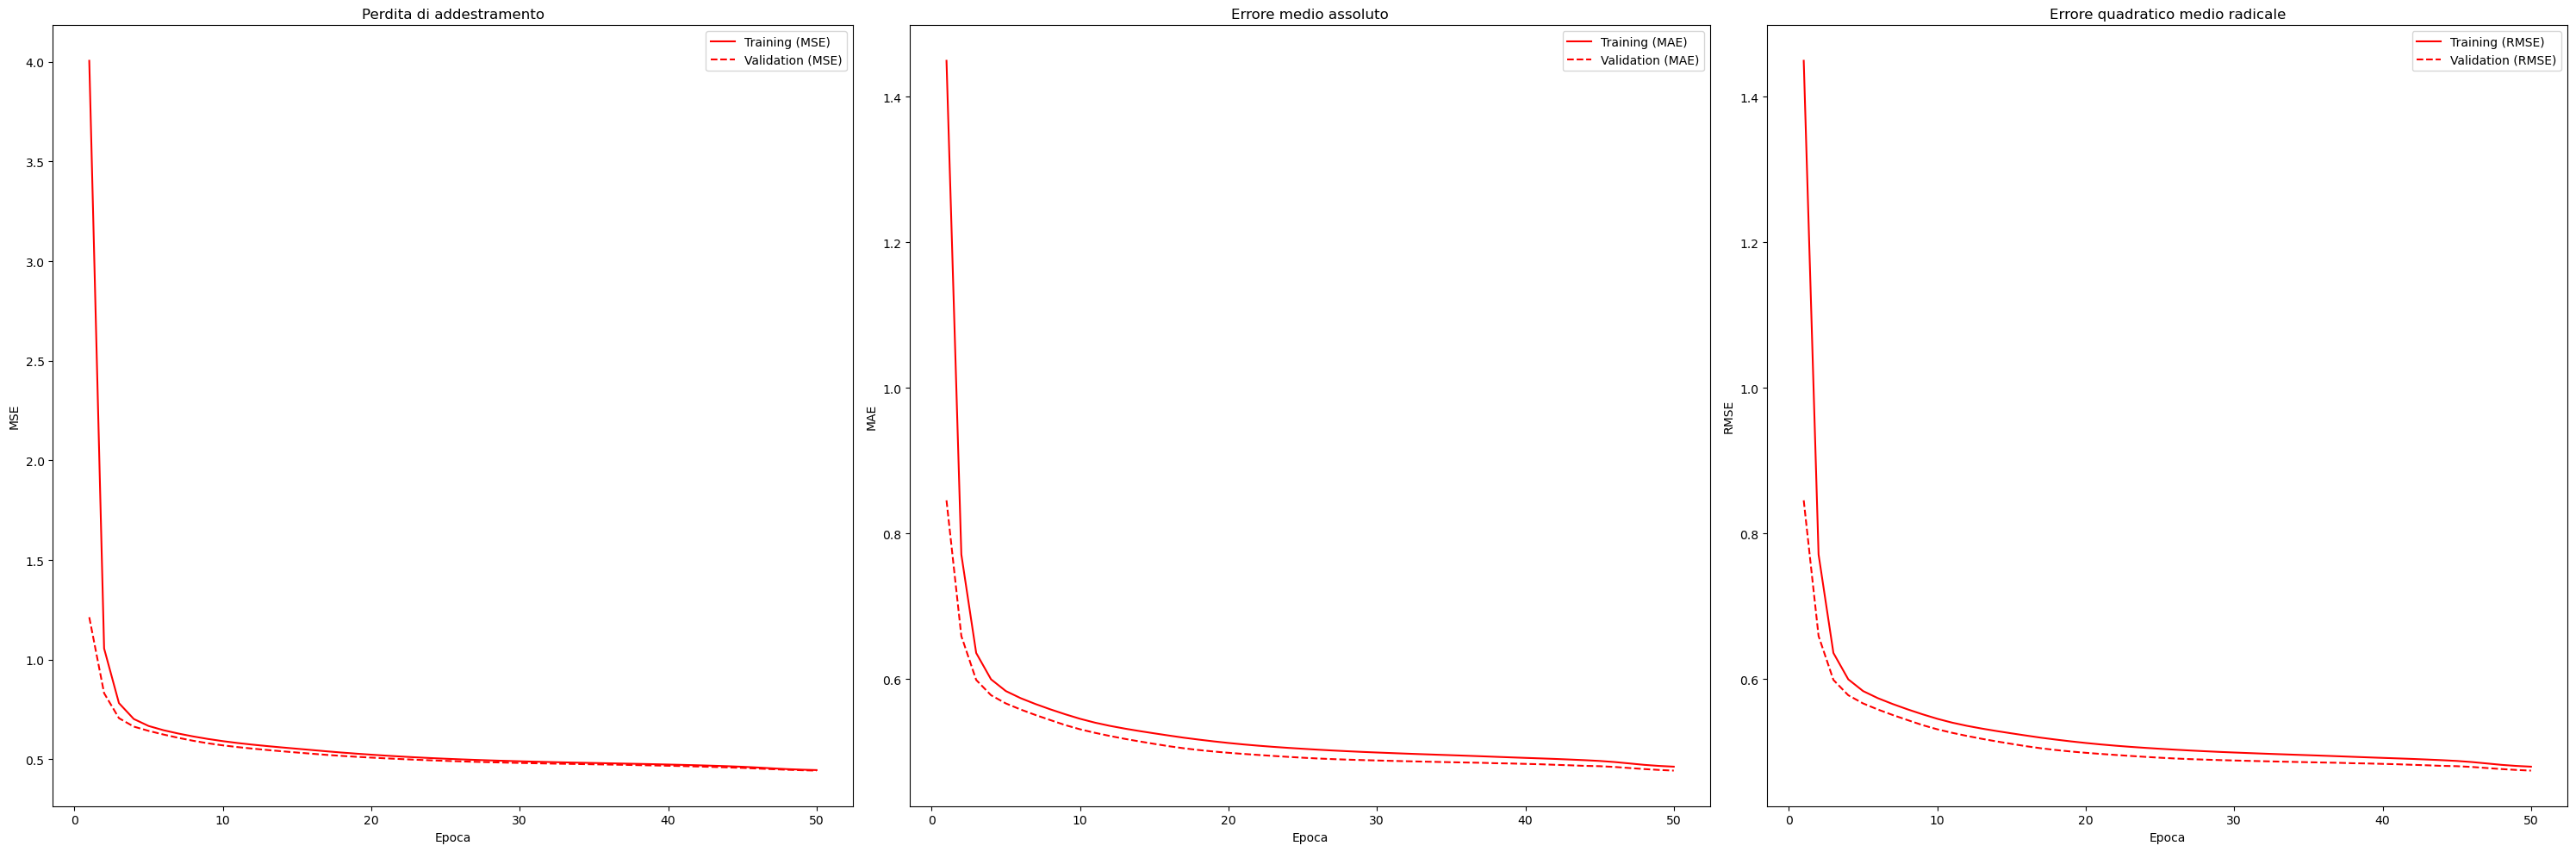

In [120]:
import matplotlib.pyplot as plt

# Supponiamo che 'kan_history' sia il risultato del tuo modello.fit()
loss = kan_history.history['loss']
val_loss = kan_history.history['val_loss']
mae = kan_history.history['mae']
val_mae = kan_history.history['val_mae']
rmse = kan_history.history['rmse']
val_rmse = kan_history.history['val_rmse']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'r', label='Training (MSE)') # linea rossa per training
plt.plot(epochs, val_loss, 'r--', label='Validation (MSE)') # linea tratteggiata rossa per validation
plt.title('Perdita di addestramento')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, mae, 'r', label='Training (MAE)') # linea rossa per training
plt.plot(epochs, val_mae, 'r--', label='Validation (MAE)') # linea tratteggiata rossa per validation
plt.title('Errore medio assoluto')
plt.xlabel('Epoca')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, rmse, 'r', label='Training (RMSE)') # linea rossa per training
plt.plot(epochs, val_rmse, 'r--', label='Validation (RMSE)') # linea tratteggiata rossa per validation
plt.title('Errore quadratico medio radicale')
plt.xlabel('Epoca')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


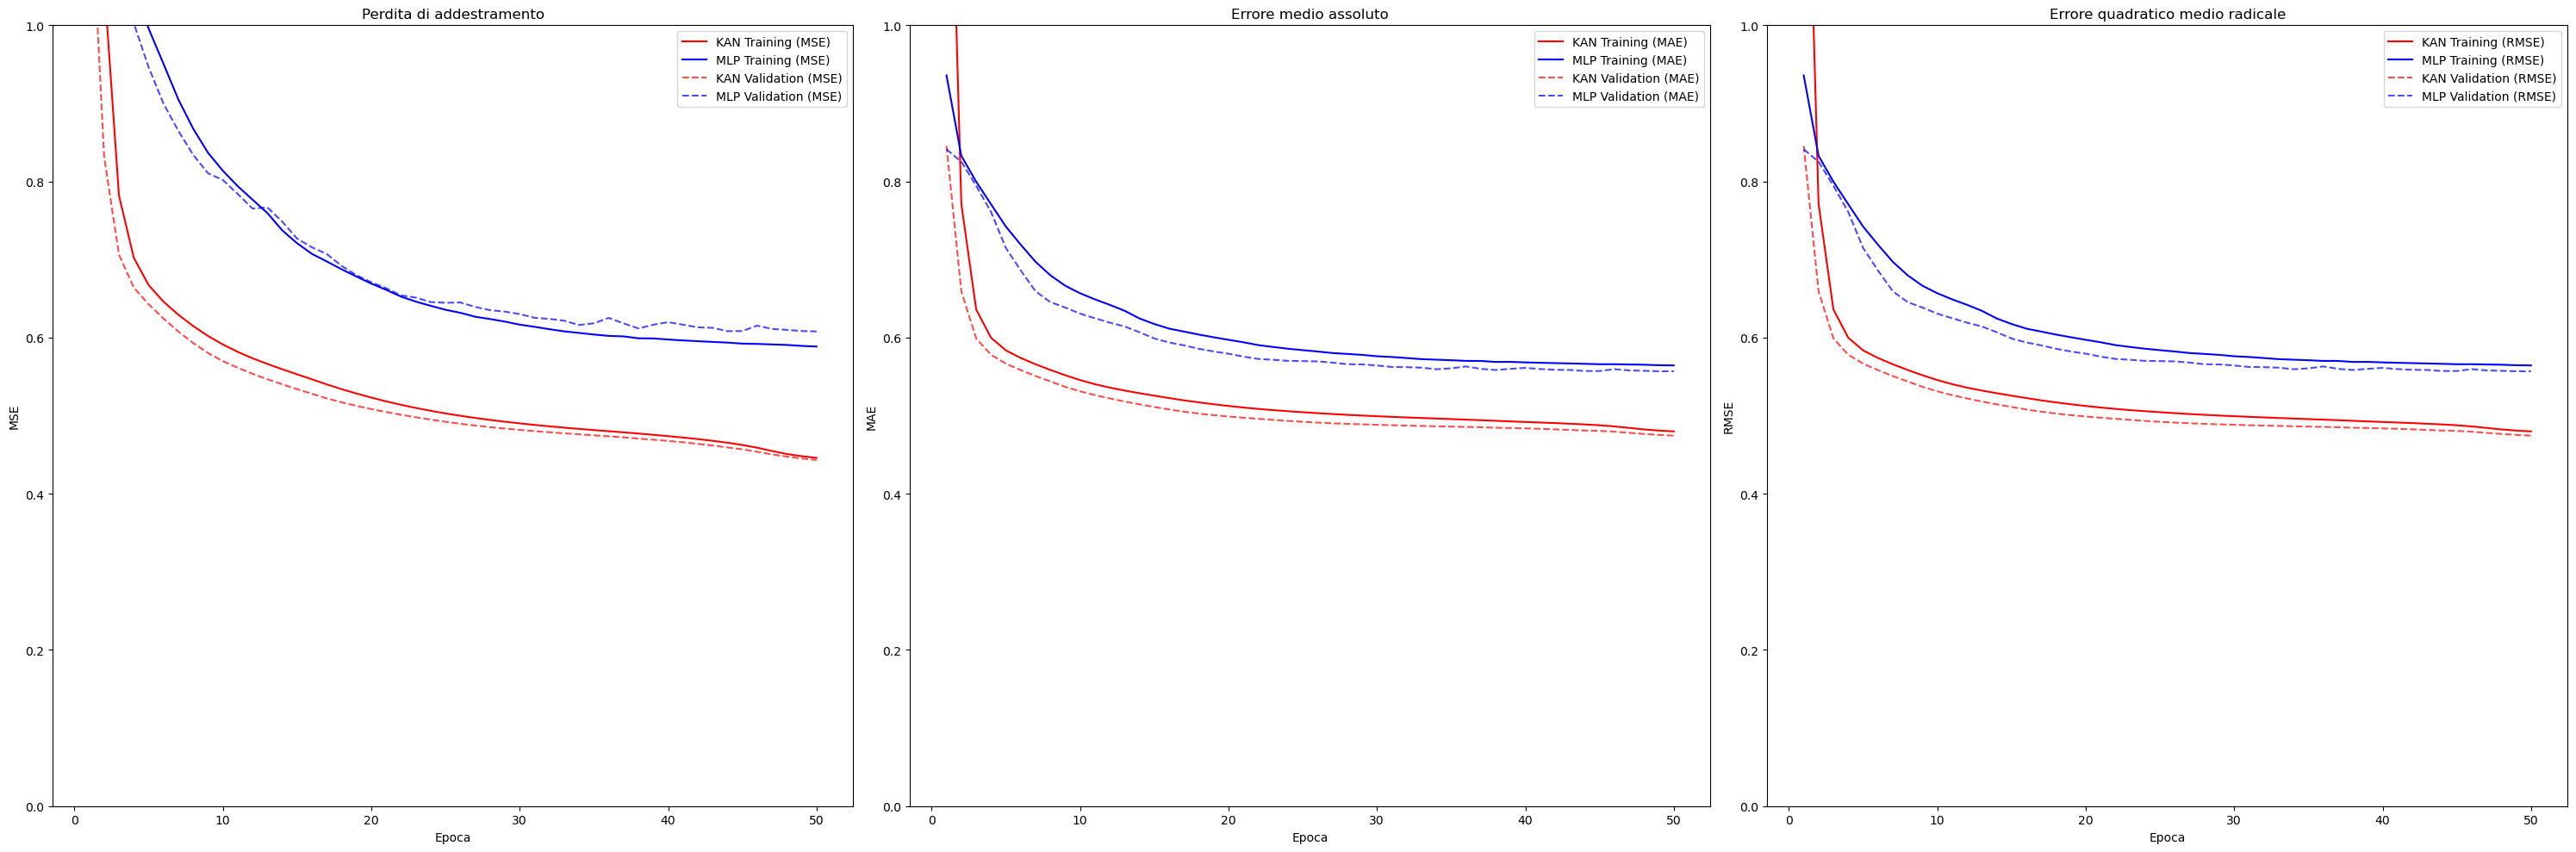

In [121]:
import matplotlib.pyplot as plt

# Supponiamo che 'kan_history' e 'mlp_history' siano i risultati del tuo modello.fit()
kan_loss = kan_history.history['loss']
kan_val_loss = kan_history.history['val_loss']
kan_mae = kan_history.history['mae']
kan_val_mae = kan_history.history['val_mae']
kan_rmse = kan_history.history['rmse']
kan_val_rmse = kan_history.history['val_rmse']

mlp_loss = mlp_history.history['loss']
mlp_val_loss = mlp_history.history['val_loss']
mlp_mae = mlp_history.history['mae']
mlp_val_mae = mlp_history.history['val_mae']
mlp_rmse = mlp_history.history['rmse']
mlp_val_rmse = mlp_history.history['val_rmse']

epochs = range(1, len(kan_loss) + 1)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(epochs, kan_loss, 'r', label='KAN Training (MSE)') # linea rossa per KAN
plt.plot(epochs, mlp_loss, 'b', label='MLP Training (MSE)') # linea blu per MLP
plt.plot(epochs, kan_val_loss, 'r--', alpha=0.7, label='KAN Validation (MSE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_loss, 'b--', alpha=0.7, label='MLP Validation (MSE)') # linea tratteggiata blu per MLP validation
plt.title('Perdita di addestramento')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, kan_mae, 'r', label='KAN Training (MAE)') # linea rossa per KAN
plt.plot(epochs, mlp_mae, 'b', label='MLP Training (MAE)') # linea blu per MLP
plt.plot(epochs, kan_val_mae, 'r--', alpha=0.7, label='KAN Validation (MAE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_mae, 'b--', alpha=0.7, label='MLP Validation (MAE)') # linea tratteggiata blu per MLP validation
plt.title('Errore medio assoluto')
plt.xlabel('Epoca')
plt.ylabel('MAE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, kan_rmse, 'r', label='KAN Training (RMSE)') # linea rossa per KAN
plt.plot(epochs, mlp_rmse, 'b', label='MLP Training (RMSE)') # linea blu per MLP
plt.plot(epochs, kan_val_rmse, 'r--', alpha=0.7, label='KAN Validation (RMSE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_rmse, 'b--', alpha=0.7, label='MLP Validation (RMSE)') # linea tratteggiata blu per MLP validation
plt.title('Errore quadratico medio radicale')
plt.xlabel('Epoca')
plt.ylabel('RMSE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.tight_layout()
plt.show()


In [122]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
results = {}

for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
    
    # Filtraggio del dataset di test per il sottogruppo corrente
    subgroup_indices = x_test[:, CATEGORY] == sg
    features = x_test[subgroup_indices]
    labels = y_test[subgroup_indices]
    
    # Calcolo delle previsioni del modello sul sottogruppo corrente
    predictions = kan.predict(features)
    
    # Calcolo delle metriche personalizzate per ciascun sottogruppo
    mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
    mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
    rmse_value = tf.sqrt(mse_value)
    
    # Memorizzazione dei risultati
    results[sg] = [mse_value, mae_value, rmse_value]

# Creazione di un DataFrame per visualizzare le metriche di performance
performance_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
pd.options.display.float_format = '{:,.4f}'.format  # Formattazione float per il DataFrame

# Stampa delle metriche di performance
print(performance_df)


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
                                                  0  \
MSE                                          0.4867   
MAE                                          0.4936   
RMSE  tf.Tensor(0.6976589, shape=(), dtype=float32)   

                                                   1  
MSE                                           0.4089  
MAE                                           0.4593  
RMSE  tf.Tensor(0.63942784, shape=(), dtype=float32)  


In [123]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
mlp_results = {}

for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
    
    # Filtraggio del dataset di test per il sottogruppo corrente
    subgroup_indices = x_test[:, CATEGORY] == sg
    features = x_test[subgroup_indices]
    labels = y_test[subgroup_indices]
    
    # Calcolo delle previsioni del modello sul sottogruppo corrente
    predictions = mlp.predict(features)
    
    # Calcolo delle metriche personalizzate per ciascun sottogruppo
    mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
    mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
    rmse_value = tf.sqrt(mse_value)
    
    # Memorizzazione dei risultati
    mlp_results['Maschio' if sg == 0 else 'Femmina'] = [mse_value, mae_value, rmse_value]

# Creazione di un DataFrame per visualizzare le metriche di performance
mlp_performance_df = pd.DataFrame(mlp_results, index=['MSE', 'MAE', 'RMSE'])
pd.options.display.float_format = '{:,.4f}'.format  # Formattazione float per il DataFrame

# Stampa delle metriche di performance
print(mlp_performance_df)


208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
                                           Maschio  \
MSE                                         0.6644   
MAE                                         0.5789   
RMSE  tf.Tensor(0.815087, shape=(), dtype=float32)   

                                            Femmina  
MSE                                          0.5631  
MAE                                          0.5393  
RMSE  tf.Tensor(0.7503965, shape=(), dtype=float32)  


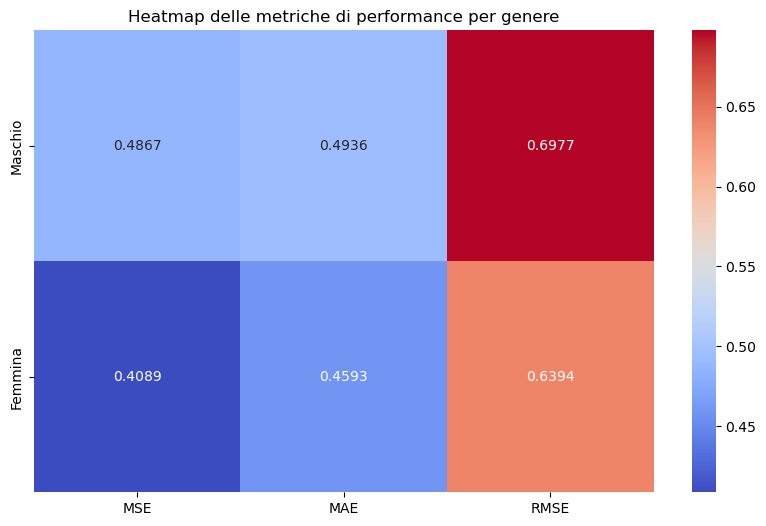

In [124]:
import seaborn as sns
import pandas as pd

# Creazione di un DataFrame per visualizzare le metriche di performance
performance_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
performance_df.columns = ['Maschio', 'Femmina']

# Conversione dei dati in float
performance_df = performance_df.astype(float)

# Trasposizione del DataFrame per avere le metriche come colonne e i valori di genere come righe
performance_df = performance_df.transpose()

# Creazione della heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Heatmap delle metriche di performance per genere')
plt.show()


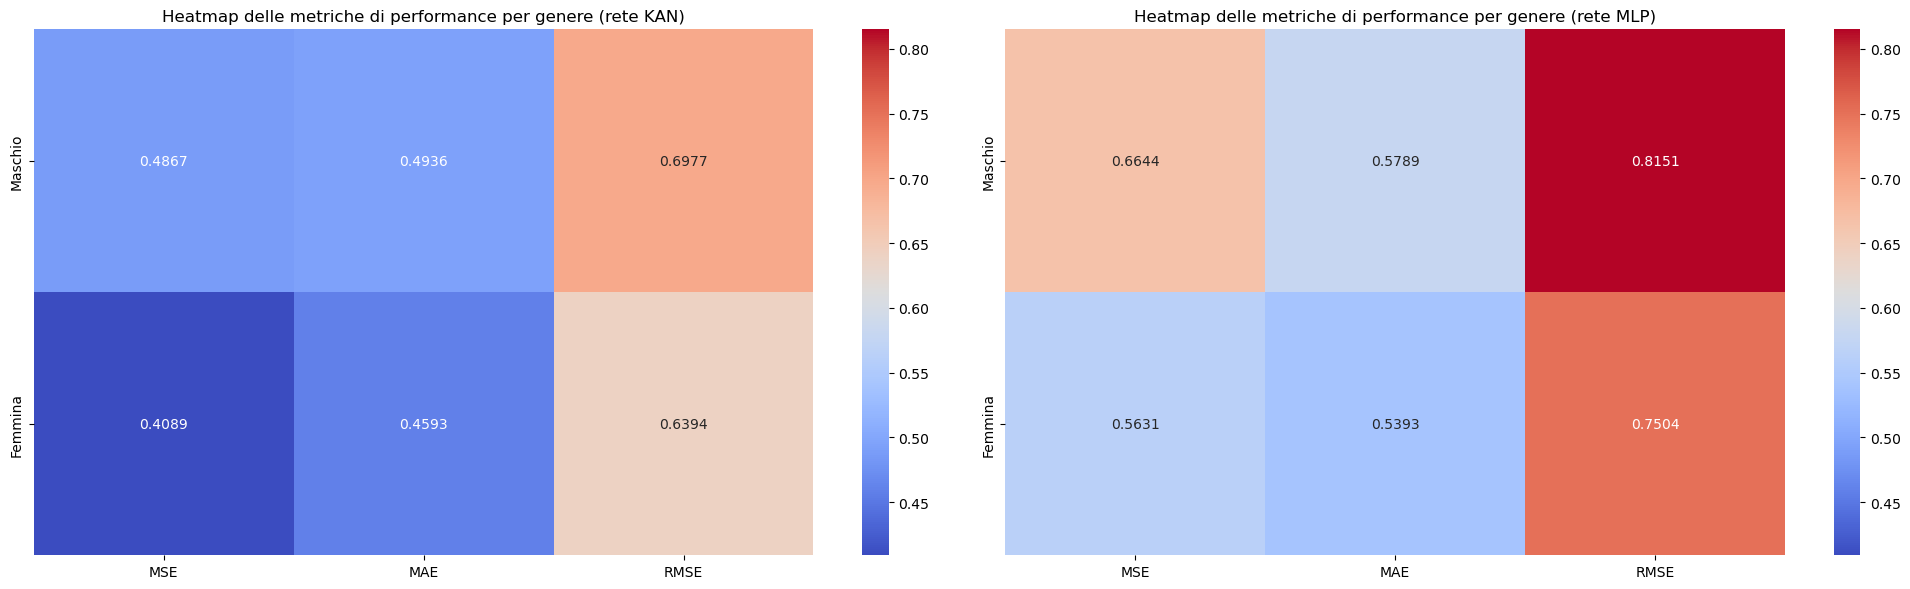

In [125]:
import seaborn as sns
import pandas as pd

# Creazione di un DataFrame per visualizzare le metriche di performance della rete KAN
kan_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
kan_df.columns = ['Maschio', 'Femmina']

# Conversione dei dati in float
kan_df = kan_df.astype(float)
mlp_performance_df = mlp_performance_df.astype(float)

# Trasposizione dei DataFrame per avere le metriche come colonne e i valori di genere come righe
kan_df = kan_df.transpose()
mlp_performance_df = mlp_performance_df.transpose()

# Calcolo dei valori minimi e massimi per la scala di colori
vmin = min(kan_df.min().min(), mlp_performance_df.min().min())
vmax = max(kan_df.max().max(), mlp_performance_df.max().max())

# Creazione delle heatmap
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.heatmap(kan_df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere (rete KAN)')

plt.subplot(1, 2, 2)
sns.heatmap(mlp_performance_df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere (rete MLP)')

plt.tight_layout()
plt.show()


In [126]:
# Lista delle caratteristiche
features = ['vdate', 'rcount', 'gender', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo', 'hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'discharged', 'facid']

def calculate_feature_importance(model, x_val, y_val):
    # Calcola l'importanza delle caratteristiche
    results = permutation_importance(model, x_val, y_val, scoring='neg_mean_squared_error')
    # Ottieni l'importanza delle caratteristiche
    importance = results.importances_mean
    # Crea un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(features, importance))
    return feature_importance

# Calcola l'importanza delle caratteristiche per i modelli
mlp_importance = calculate_feature_importance(mlp, x_test, y_test)
kan_importance = calculate_feature_importance(kan, x_test, y_test)


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
469/469 ━━━

In [127]:
print("Importanza delle caratteristiche per il modello MLP:")
for feature, importance in mlp_importance.items():
    print(f"Caratteristica: {feature}, Importanza: {importance}")

print("\nImportanza delle caratteristiche per il modello KAN:")
for feature, importance in kan_importance.items():
    print(f"Caratteristica: {feature}, Importanza: {importance}")

Importanza delle caratteristiche per il modello MLP:
Caratteristica: vdate, Importanza: 2.8822623610496523
Caratteristica: rcount, Importanza: 6.416663777828217
Caratteristica: gender, Importanza: 0.0022361040115356444
Caratteristica: dialysisrenalendstage, Importanza: 0.07869812250137329
Caratteristica: asthma, Importanza: 0.11696131229400634
Caratteristica: irondef, Importanza: 0.2095160961151123
Caratteristica: pneum, Importanza: 0.08075348138809205
Caratteristica: substancedependence, Importanza: 0.14688073396682738
Caratteristica: psychologicaldisordermajor, Importanza: 0.6564797520637512
Caratteristica: depress, Importanza: 0.07290208339691162
Caratteristica: psychother, Importanza: 0.07950540781021118
Caratteristica: fibrosisandother, Importanza: 0.029239940643310546
Caratteristica: malnutrition, Importanza: 0.06942262649536132
Caratteristica: hemo, Importanza: 0.21421496868133544
Caratteristica: hematocrit, Importanza: 0.21366393566131592
Caratteristica: neutrophils, Importanza

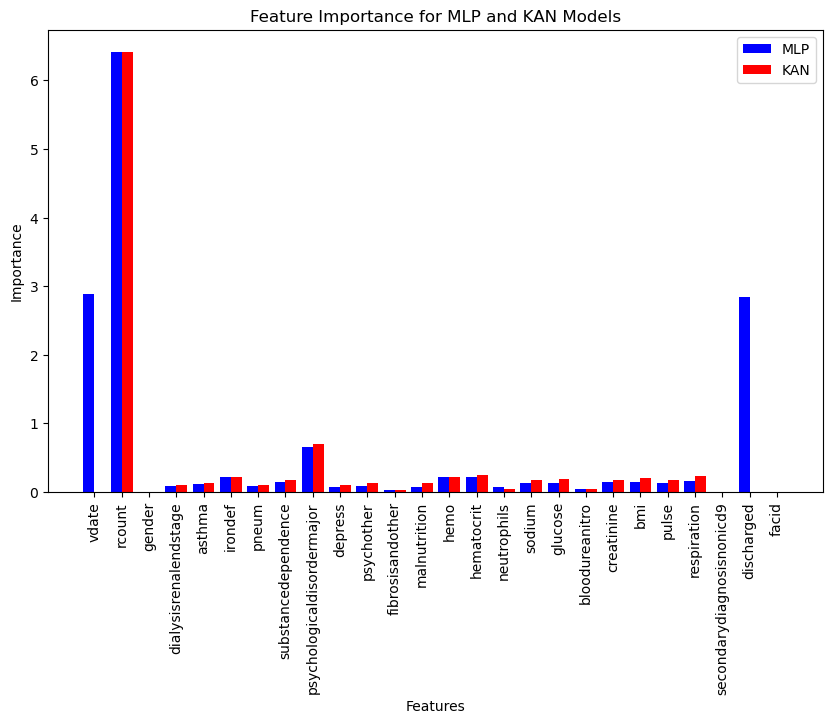

In [128]:

# Crea le etichette per l'asse x
x = np.arange(len(mlp_importance))

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(10, 6))  # Modifica le dimensioni qui

# Crea le barre per l'importanza delle caratteristiche del modello MLP
bar1 = ax.bar(x - 0.2, list(mlp_importance.values()), 0.4, label='MLP', color='blue')

# Crea le barre per l'importanza delle caratteristiche del modello KAN
bar2 = ax.bar(x + 0.2, list(kan_importance.values()), 0.4, label='KAN', color='red')

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for MLP and KAN Models')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90)
ax.legend()

# Mostra il grafico
plt.show()